# This is the work of clustering  caffe and restaurants in Moscow data
## Target of the work is to choose nearest caffe or restaurant in category

### For accomplishing this target I need to:
    - collect data of caffe and restaurants in Moscow using foursquare
    - merge both data to one dataframe
    - clean and prepare dataset
    - make clusterization analysis
    - visualize dataset objects
    - visualize clusters
    - make recomendation on example coordinates and object category type
    - visualize recomendation place on map

In [291]:
import requests
import pandas as pd
import numpy as np 
import random 

!pip install geopy
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

from IPython.display import Image 
from IPython.core.display import HTML 
    
from pandas.io.json import json_normalize

! pip install folium==0.5.0
import folium # plotting library

## Making my credentials not visible

In [136]:
CLIENT_ID = '4IT5LW32G33RRE2PAEOAUIFU0HF4QTSUXWDFL5M0OS0WIBZX' # your Foursquare ID
CLIENT_SECRET = '434S03JEUQF344MNDPFHT45WP1FDNEGR05XROFCT5JNAUHGL' # your Foursquare Secret
ACCESS_TOKEN = 'BOFVT1VJC1GHEVRGOUS5RDGAH5EMDDXPVMXDQJKH10HNXLGX' # your FourSquare Access Token

VERSION = '20180604'
LIMIT = 30
# print('Your credentails:')
# print('CLIENT_ID: ' + CLIENT_ID)
# print('CLIENT_SECRET:' + CLIENT_SECRET)

## Getting rastaurants at moscow

In [273]:
import time
url = f'''https://api.foursquare.com/v2/venues/search?
categoryId=4bf58dd8d48988d1cc941735&near=Moscow&limit=300&oauth_token={ACCESS_TOKEN}&v=20170901'''

query = 'restaurant'
LIMIT = 200

url2 = f'''https://api.foursquare.com/v2/venues/search?client_id=
{CLIENT_ID}&client_secret={CLIENT_SECRET}&v={VERSION}&query={query}&near=Moscow&limit={LIMIT}'''


NUM_ITERS = 15
QUERY = 'restaurant'  # made two queries caffe and restaurant


res_of_requests = []
for frm in range(0, NUM_ITERS*50, 50):
    try:
        url3 = f'''https://api.foursquare.com/v2/venues/explore?client_id={CLIENT_ID}&client_secret={CLIENT_SECRET}&v={VERSION}
            &near=Moscow&query={QUERY}&limit=50&offset={frm}'''
        res = requests.get(url3)
        json_data = res.json()
        res_of_requests.append(json_data)
        time.sleep(0.6)
        print('offset now is:', frm)
    except Exception as e:
        print(e)

offset now is: 0
offset now is: 50
offset now is: 100
offset now is: 150
offset now is: 200
offset now is: 250
offset now is: 300
offset now is: 350
offset now is: 400
offset now is: 450
offset now is: 500
offset now is: 550
offset now is: 600
offset now is: 650
offset now is: 700


In [275]:
restaurant = []
for i in range(NUM_ITERS):
    restaurant.extend([ item['venue'] for item in res_of_requests[i]['response']['groups'][0]['items'] ])
    
restaurant.__len__()

229

## Making Caffe Dataframe and cleaning it

In [283]:
df = pd.DataFrame(all_items)
# category name
df['category_name'] = df.categories.apply(lambda x: x[0]['name'])

# venuePage
df.venuePage.isna().sum() # 248 from 272 enteries are null then dropping column

# photos
print(len(df.photos.apply(lambda x: x['count']).unique()), df.photos.apply(lambda x: x['count']).unique(),
      'so there are no photos then dropping the column')

# location

df.location[0]
df['lat'] = df.location.apply(lambda x: float(x['lat']))
df['lng'] = df.location.apply(lambda x: float(x['lng']))
df['address'] = df.location.apply(lambda x: str(x.get('address', 'Not stated')))

df.drop(columns=['venuePage', 'photos', 'location', 'categories'], inplace=True)
print('cafes with no address but with lat and lng: ',df[df.address == 'Not stated'].shape[0])

df

1 [0] so there are no photos then dropping the column
cafes with no address but with lat and lng:  22


,id,name,category_name,lat,lng,address
0,5749bebe38fa943555051929,Sky Food Cafe,Café,55.678915,37.635942,"1-й Нагатинский пр., 11, корп. 1"
1,54ce1f63498e57df0bc8c307,Торшер,Café,55.713566,37.750770,"ул. Васильцовский Стан, 5, корп. 1"
2,5ef0b8a5579b510008e601d2,Sur,Café,55.755193,37.644523,2 Bolshoy Trekhsvyatitelskiy Lane
3,5c0267106adbf5002c28170c,Андерсон,Café,55.778272,37.456181,Маршала Жукова 59
4,5c8fbf87d48ec1003973ff5c,Брусника,Café,55.738810,37.576400,"Плющиха, 53/25 ст1 / Бурденко, 25"
...,...,...,...,...,...,...
267,4c0a7e08bbc676b072e249d5,McDonald's,Fast Food Restaurant,55.750213,37.817211,"Свободный просп., 35Б"
268,4c0772808a81c9b687392790,McDonald's,Fast Food Restaurant,55.788733,37.681205,"Русаковская ул., 26"
269,4eb900cfe30006eb139d5255,Fornetto,Pizza Place,55.734010,37.589927,"ул. Тимура Фрунзе, 11, стр. 2"
270,4c066d3f191f20a1147be414,Столовая № 57,Cafeteria,55.754186,37.623217,"Красная пл., 3"


In [284]:
df.to_csv('caffe_272_6.csv', index=False)

## Cleaning Restaurant Dataset

In [285]:
df2 = pd.DataFrame(restaurant)
# category name
df2['category_name'] = df2.categories.apply(lambda x: x[0]['name'])

# venuePage
df2.venuePage.isna().sum() # 248 from 272 enteries are null then dropping column

# photos
print(len(df2.photos.apply(lambda x: x['count']).unique()), df2.photos.apply(lambda x: x['count']).unique(),
      'so there are no photos then dropping the column')

# location

df2.location[0]
df2['lat'] = df2.location.apply(lambda x: float(x['lat']))
df2['lng'] = df2.location.apply(lambda x: float(x['lng']))
df2['address'] = df2.location.apply(lambda x: str(x.get('address', 'Not stated')))

df2.drop(columns=['venuePage', 'photos', 'location', 'categories'], inplace=True)
print('cafes with no address but with lat and lng: ',df2[df.address == 'Not stated'].shape[0])

df2

1 [0] so there are no photos then dropping the column
cafes with no address but with lat and lng:  16


C:\ProgramData\Miniconda3\envs\env\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


,id,name,category_name,lat,lng,address
0,5264d482498eaec54f69a2a1,Buffalo's,Wings Joint,55.693040,37.534257,"пл. Джавахарлала Неру, 1"
1,592a9d3e0d8a0f2067c5c328,Лепим и варим,Pelmeni House,55.777453,37.632790,Ботанический сад МГУ «Аптекарский огород»
2,5db327590b0e5000084b6eb4,Mission,Vegetarian / Vegan Restaurant,55.770472,37.670961,Спартаковская 3с3
3,5543b2c7498e2c25c5f9ebfb,Lao Lee,Vietnamese Restaurant,55.778711,37.596621,"Миусская пл., 9, стр. 11"
4,5a36b65bc0f16360b99db654,Streat,Food Court,55.709096,37.653011,"ул. Ленинская Слобода, 26"
...,...,...,...,...,...,...
224,5cbadff63149b9002c0e6a6c,Taco Project,Taco Place,55.778907,37.598702,"Весковский пер., 3"
225,56509202498edc18119f7533,Оджахури,Caucasian Restaurant,55.764361,37.655435,"Садово-Черногрязская ул., 22, стр. 1"
226,5b1ace67f15b51002c847ee0,Mercedes-Benz Café,Café,55.981435,37.415883,Шереметьево B / SVO B
227,5bd70bf0db2aeb002cd027e0,"Мясной ресторан ""ОХОТА""",Restaurant,55.676807,37.094390,Одинцовский район деревня Семенково стр. 1


In [286]:
df2.to_csv('restaurant_229_6.csv', index=False)

## Union of caffe and restaurant data

In [338]:
res_df = pd.concat([df, df2], axis=0)
res_df

,id,name,category_name,lat,lng,address
0,5749bebe38fa943555051929,Sky Food Cafe,Café,55.678915,37.635942,"1-й Нагатинский пр., 11, корп. 1"
1,54ce1f63498e57df0bc8c307,Торшер,Café,55.713566,37.750770,"ул. Васильцовский Стан, 5, корп. 1"
2,5ef0b8a5579b510008e601d2,Sur,Café,55.755193,37.644523,2 Bolshoy Trekhsvyatitelskiy Lane
3,5c0267106adbf5002c28170c,Андерсон,Café,55.778272,37.456181,Маршала Жукова 59
4,5c8fbf87d48ec1003973ff5c,Брусника,Café,55.738810,37.576400,"Плющиха, 53/25 ст1 / Бурденко, 25"
...,...,...,...,...,...,...
224,5cbadff63149b9002c0e6a6c,Taco Project,Taco Place,55.778907,37.598702,"Весковский пер., 3"
225,56509202498edc18119f7533,Оджахури,Caucasian Restaurant,55.764361,37.655435,"Садово-Черногрязская ул., 22, стр. 1"
226,5b1ace67f15b51002c847ee0,Mercedes-Benz Café,Café,55.981435,37.415883,Шереметьево B / SVO B
227,5bd70bf0db2aeb002cd027e0,"Мясной ресторан ""ОХОТА""",Restaurant,55.676807,37.094390,Одинцовский район деревня Семенково стр. 1


## Preparing data for clustering

In [339]:
from sklearn.preprocessing import LabelEncoder

category_le = LabelEncoder()
category_le.fit(res_df.category_name)
res_df['category_encoded'] = category_le.transform(res_df.category_name)

clustering_df = res_df.drop(columns=['id', 'name', 'category_name', 'address'])
clustering_df

,lat,lng,category_encoded
0,55.678915,37.635942,10
1,55.713566,37.750770,10
2,55.755193,37.644523,10
3,55.778272,37.456181,10
4,55.738810,37.576400,10
...,...,...,...
224,55.778907,37.598702,53
225,55.764361,37.655435,11
226,55.981435,37.415883,10
227,55.676807,37.094390,42


## Making clustering analysis with elbow method

Index(['lat', 'lng', 'category_encoded'], dtype='object')


Text(0.5, 1.0, 'Elbow curve')

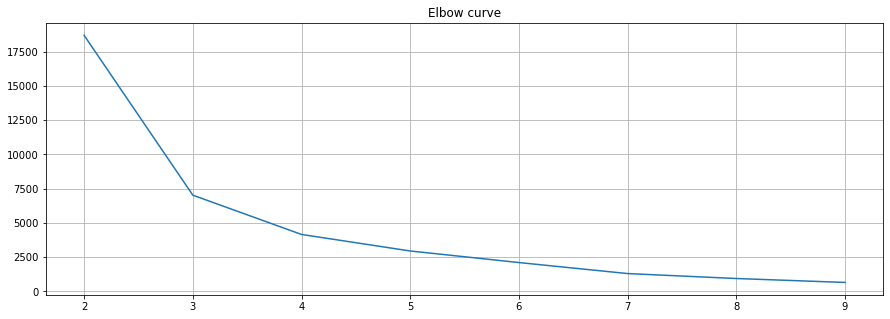

In [362]:
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

print(clustering_df.columns)


distorsions = []
for k in range(2, 10, 1):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(clustering_df)
    distorsions.append(kmeans.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 10, 1), distorsions)
plt.grid(True)
plt.title('Elbow curve')

best number of clusters is 4

In [363]:
kmeans_best = KMeans(n_clusters=4, random_state=42)
predicted_clusters = kmeans_best.fit_predict(clustering_df)

## Adding cluster to our DataFrame

In [364]:
res_df.shape, predicted_clusters.shape
res_df['cluster'] = predicted_clusters
res_df

,id,name,category_name,lat,lng,address,category_encoded,cluster
0,5749bebe38fa943555051929,Sky Food Cafe,Café,55.678915,37.635942,"1-й Нагатинский пр., 11, корп. 1",10,0
1,54ce1f63498e57df0bc8c307,Торшер,Café,55.713566,37.750770,"ул. Васильцовский Стан, 5, корп. 1",10,0
2,5ef0b8a5579b510008e601d2,Sur,Café,55.755193,37.644523,2 Bolshoy Trekhsvyatitelskiy Lane,10,0
3,5c0267106adbf5002c28170c,Андерсон,Café,55.778272,37.456181,Маршала Жукова 59,10,0
4,5c8fbf87d48ec1003973ff5c,Брусника,Café,55.738810,37.576400,"Плющиха, 53/25 ст1 / Бурденко, 25",10,0
...,...,...,...,...,...,...,...,...
224,5cbadff63149b9002c0e6a6c,Taco Project,Taco Place,55.778907,37.598702,"Весковский пер., 3",53,2
225,56509202498edc18119f7533,Оджахури,Caucasian Restaurant,55.764361,37.655435,"Садово-Черногрязская ул., 22, стр. 1",11,0
226,5b1ace67f15b51002c847ee0,Mercedes-Benz Café,Café,55.981435,37.415883,Шереметьево B / SVO B,10,0
227,5bd70bf0db2aeb002cd027e0,"Мясной ресторан ""ОХОТА""",Restaurant,55.676807,37.094390,Одинцовский район деревня Семенково стр. 1,42,1


## Lets visualize our restaurants and caffe

In [365]:
from geopy.geocoders import Nominatim

address = 'Moscow'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Moscow are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Moscow are 55.7504461, 37.6174943.


In [366]:
moscow_map = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, label in zip(res_df['lat'], res_df['lng'], res_df['name']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=4,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(moscow_map)  
moscow_map

## Lets visualize predicted clusters

In [372]:
import matplotlib.cm as cm
import matplotlib.colors as colors

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(8)
ys = [i + x + (i*x)**2 for i in range(8)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, cat in zip(res_df['lat'], res_df['lng'], res_df['name'], res_df['cluster'], res_df['category_name']):
    label = folium.Popup(str(poi) +'\n' + str(cat) + 'cluster:' + str(cluster) + '\n' + str(lat) +', ' + str(lon), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.6).add_to(map_clusters)
       
map_clusters

# That`s maybe okey and now we should make prediction of best suitable caffe or restaurant

In [408]:
# let`s get some example lat, lon values to make prediction
input_lat = 55.75
input_lng = 37.6
preffered_category = 'Restaurant'  #  also check 'Restaurant'/'Café'

encoded_category = category_le.transform([preffered_category,])

In [409]:
cluster = kmeans_best.predict(pd.DataFrame({'lat':[input_lat,], 'lng': [input_lng,],
                                            'category_encoded': [encoded_category,]}))

cluster[0]

1

### Now lets find nearest object to client in this cluster

In [410]:
nearest_id = None
min_dist = None

filtered_df = res_df[res_df.cluster == cluster[0]]

for id, lat, lng in zip(filtered_df.id, filtered_df.lat, filtered_df.lng):
    computed_distance = np.sqrt(np.power(np.abs(input_lng-lng),2) + np.power(np.abs(input_lat-lat), 2))
    if min_dist == None or min_dist > computed_distance:
        min_dist = computed_distance
        nearest_id = id

print(nearest_id, min_dist)

546e146b498e86d7178d336d 0.004503479210567992


In [412]:
result = filtered_df[filtered_df.id == nearest_id]
print(f'''
    Hello, the nearest {preffered_category} to you
    is {list(result.name)[0]} it`s address
    {list(result.address)[0]}
    you can see it on map under )
''')


    Hello, the nearest Restaurant to you
    is Pinzeria by Bontempi it`s address
    Большой Знаменский пер., 2, стр. 3
    you can see it on map under )



In [420]:
target_map = folium.Map(location=[latitude, longitude], zoom_start=14)

# add markers to map
for lat, lng, label, adr in zip(result['lat'], result['lng'], result['name'], result['address']):
    label = folium.Popup(str(label)+'\n' + str(adr), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=10,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.9,
        parse_html=False).add_to(target_map)  
target_map